In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.image as imd

import warnings

import random

import os

warnings.filterwarnings('ignore')


In [6]:
train_path = '/Users/didaryilmaz/Documents/GitHub/Smoking_Detection/Smooking Detection.v4i.yolov8/train/images'
valid_path = '/Users/didaryilmaz/Documents/GitHub/Smoking_Detection/Smooking Detection.v4i.yolov8/valid/images'

In [7]:
def extract_from_path(path)-> []:
    full_path = []
    for i in sorted(os.listdir(path)):
        full_path.append(os.path.join(path, i))
    return full_path

In [8]:
train_images = extract_from_path(train_path)
valid_images = extract_from_path(valid_path)

print(f"The length of train_images is {len(train_images)}")
print(f"The length of valid_images is {len(valid_images)}")

The length of train_images is 5059
The length of valid_images is 302


In [9]:
def createDataFrame(image_paths):
    labels = [path.split('/')[-1].split('_')[0] for path in image_paths]
    df = pd.DataFrame({'path': image_paths, 'label': labels})
    df['label_id'] = df['label'].apply(lambda x: 1 if x == 'smoking' else 0)
    return df

In [10]:
train_images_df = createDataFrame(train_images)
valid_images_df = createDataFrame(valid_images)

In [11]:
def plotCount(df):
    name = df["path"][0].split("/")[4]
    smoking = df[df['label_id'] == 1]    
    print(f"Total images in {name} is {len(df)}")
    print(f"Total smoking images is {len(smoking)}")
    print(f"Total non-smoking images is {len(df)-len(smoking)}")
    sns.set_style("whitegrid")
    sns.countplot(x='label_id', data=df)

Total images in GitHub is 5059
Total smoking images is 1387
Total non-smoking images is 3672


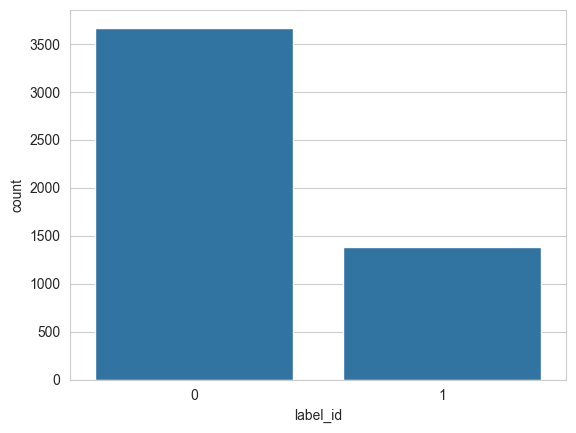

In [12]:
plotCount(train_images_df)

Total images in GitHub is 302
Total smoking images is 82
Total non-smoking images is 220


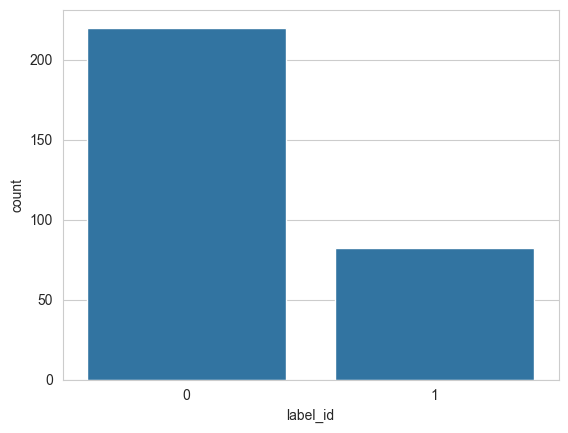

In [13]:
plotCount(valid_images_df)

In [14]:
train_images_df

,path,label,label_id
0,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,01F7SPZHIVLR,0
1,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,01F7SPZHIVLR,0
2,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,01F7SPZHIVLR,0
3,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,05G13BWZVLKE,0
4,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,05G13BWZVLKE,0
...,...,...,...
5054,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,smoking,1
5055,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,smoking,1
5056,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,smoking,1
5057,/Users/didaryilmaz/Documents/GitHub/Smoking_De...,smoking,1


In [15]:
import tensorflow as tf

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

def imgPreProcessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMAGE_SIZE))
    return img, label
def loadDataset(df:pd.DataFrame):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'], df['label_id']))
    return (dataset
                 .map(imgPreProcessing)
                .shuffle(BATCH_SIZE * 20)
                 .batch(BATCH_SIZE))

In [16]:
train_data = loadDataset(train_images_df)
valid_data = loadDataset(valid_images_df)

In [17]:
# Eğitim verilerinden bazı rastgele görüntüleri görselleştirdim

def plotRandom(data):
    for img,label in data.take(1):
        randomNum = random.randint(0, BATCH_SIZE - 1)
        text_label = "Smoking" if label[randomNum].numpy() == 1 else "Non-Smoking"
        plt.figure(figsize=(4, 4))
        plt.imshow(img[randomNum]/255.)
        plt.title(text_label)
        plt.axis('off') 
        plt.show()

In [18]:
def create_b0_base(lr:float = 0.001)->tf.keras.Model:
    model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    model.trainable = False
    
    input_ = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name = "input layer")
    x = model(input_)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(2,activation = "sigmoid")(x)
    
    base_model = tf.keras.Model(input_,output)
    base_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate = lr), metrics = ["accuracy"])
    return base_model

In [19]:
def plot_history(model_history):
    plt.style.use("seaborn-v0_8-whitegrid")
    df = pd.DataFrame(model_history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    loss = df['loss']
    accuracy = df['accuracy']
    val_loss = df['val_loss']
    val_accuracy = df['val_accuracy']
    epochs = range(len(df['val_loss']))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_title("Loss")
    
    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    ax2.set_title("Accuracy")
    
    plt.tight_layout()
    plt.show()

In [22]:
import os
import shutil

# Dataset yolları
data_dir = "/Users/didaryilmaz/Documents/GitHub/Smoking_Detection/Smooking Detection.v4i.yolov8"
train_images_dir = os.path.join(data_dir, "train/images")
train_labels_dir = os.path.join(data_dir, "train/labels")
valid_images_dir = os.path.join(data_dir, "valid/images")
valid_labels_dir = os.path.join(data_dir, "valid/labels")
data_yaml = os.path.join(data_dir, "data.yaml")

def dataset_location():
    return data_dir

# Dataset kontrolü
if not all([os.path.exists(train_images_dir), os.path.exists(train_labels_dir), 
            os.path.exists(valid_images_dir), os.path.exists(valid_labels_dir), os.path.exists(data_yaml)]):
    raise FileNotFoundError("Dataset dosyaları eksik veya yanlış bir yapıda.")

print("Dataset yapısı doğru ve kullanıma hazır.")

# YOLOv8 ile eğitim yapmak için terminalde çalıştırılacak komutları hazırladım
def generate_yolov8_command():
    train_command = (
        f"yolo task=detect mode=train epochs=50 batch=16 plots=True "
        f"model=yolov8n.pt data={data_yaml} imgsz=640"
    )
    return train_command

# YOLOv8 komutunu yazdırdım
train_command = generate_yolov8_command()
print(train_command)


Dataset yapısı doğru ve kullanıma hazır.
yolo task=detect mode=train epochs=50 batch=16 plots=True model=yolov8n.pt data=/Users/didaryilmaz/Documents/GitHub/Smoking_Detection/Smooking Detection.v4i.yolov8/data.yaml imgsz=640


In [23]:
from ultralytics import YOLO

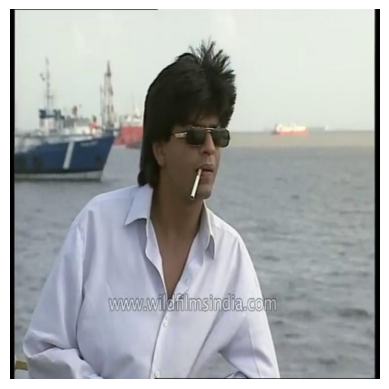

In [27]:
import os
import matplotlib.pyplot as plt
import cv2  

image_path = '/Users/didaryilmaz/Documents/GitHub/Smoking_Detection/Smooking Detection.v4i.yolov8/valid/images'

# Dizindeki tüm resim dosyalarının listesini aldım
image_files = os.listdir(image_path)

for i, image_file in enumerate(image_files):
    image = cv2.imread(f'{image_path}/{image_file}')  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Düzgün görüntüleme için BGR'yi RGB'ye dönüştürdüm

    plt.imshow(image)
    plt.axis('off') 
    plt.show()

    break  


In [11]:
import os
from pathlib import Path
import subprocess

dataset_location = '/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8'

# data.yaml dosyasının tam yolunu oluşturma
data_yaml_path = os.path.join(dataset_location, 'data.yaml')

command = [
    'yolo', 
    'task=detect', 
    'mode=train', 
    'epochs=30', 
    'batch=8', 
    'plots=True', 
    f'model=yolov8n.pt',
    f'data={data_yaml_path}', 
    'imgsz=416'
]

subprocess.run(command)


New https://pypi.org/project/ultralytics/8.3.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.49 🚀 Python-3.9.21 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/data.yaml, epochs=30, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

train: Scanning /Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/train/labels.cache... 5059 images, 3 backgrounds, 0 corrupt: 100%|██████████| 5059/5059 [00:00<?, ?it/s]
val: Scanning /Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/valid/labels.cache... 302 images, 0 backgrounds, 0 corrupt: 100%|██████████| 302/302 [00:00<?, ?it/s]


Plotting labels to /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.257      2.566      1.596          4        416: 100%|██████████| 633/633 [05:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


                   all        302        316      0.547      0.474      0.451      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      2.266      2.026      1.643          6        416: 100%|██████████| 633/633 [12:23<00:00,  1.17s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.636      0.516      0.533      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      2.251      1.887      1.639          3        416: 100%|██████████| 633/633 [05:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.579      0.553      0.528      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      2.193      1.804      1.606          7        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316        0.6      0.603      0.593      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      2.142      1.708      1.575          6        416: 100%|██████████| 633/633 [05:29<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.632      0.642      0.583      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      2.107      1.613      1.546          4        416: 100%|██████████| 633/633 [05:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.677      0.611      0.662      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      2.073      1.545      1.541          3        416: 100%|██████████| 633/633 [05:36<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.747      0.658      0.702      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G       2.02       1.48      1.493          3        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.775      0.693      0.744      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G       2.01      1.395      1.486          4        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:22<00:00,  1.17s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.757      0.693      0.756      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.995      1.373      1.474          4        416: 100%|██████████| 633/633 [05:30<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.769      0.734      0.758      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.959        1.3      1.445          0        416: 100%|██████████| 633/633 [05:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.821      0.734      0.787      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.934      1.285      1.426          3        416: 100%|██████████| 633/633 [05:36<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316       0.83      0.715      0.815      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.919      1.257      1.427          4        416: 100%|██████████| 633/633 [05:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.802      0.741      0.785      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G        1.9      1.229      1.408          3        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.849      0.715        0.8      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.865      1.173      1.396          6        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316       0.81      0.754      0.806       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.864      1.183      1.394          7        416: 100%|██████████| 633/633 [05:26<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316       0.82      0.762      0.827       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.837      1.144      1.378          3        416: 100%|██████████| 633/633 [05:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:22<00:00,  1.16s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.842       0.76      0.822      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.798      1.094      1.363          2        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.836       0.81      0.846      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.793      1.076       1.36          9        416: 100%|██████████| 633/633 [05:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.853      0.771      0.839      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.773       1.05      1.343          4        416: 100%|██████████| 633/633 [05:25<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.895      0.755      0.856      0.367
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.725     0.8862      1.377          3        416: 100%|██████████| 633/633 [05:20<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.818      0.795      0.854      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.676     0.8375       1.35          2        416: 100%|██████████| 633/633 [05:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.853      0.771      0.853       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.671     0.8184      1.346          3        416: 100%|██████████| 633/633 [05:26<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:22<00:00,  1.16s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.867      0.785       0.85      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.623     0.8088      1.318          4        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.855      0.801      0.862      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G       1.59     0.7709      1.301          3        416: 100%|██████████| 633/633 [05:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.809       0.82      0.853      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.567     0.7567      1.286          3        416: 100%|██████████| 633/633 [05:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.837      0.816       0.86      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.553     0.7351      1.273          3        416: 100%|██████████| 633/633 [05:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.835      0.858      0.859      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.516     0.7196      1.256          3        416: 100%|██████████| 633/633 [05:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.876      0.804      0.879       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.491      0.709      1.244          3        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.832      0.817      0.865      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.463     0.6913      1.227          3        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:36<00:00,  1.90s/it]


                   all        302        316      0.822      0.832      0.872      0.381

30 epochs completed in 3.038 hours.
Optimizer stripped from /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/weights/last.pt, 6.2MB
Optimizer stripped from /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/weights/best.pt, 6.2MB

Validating /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.9.21 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:01<00:00,  3.22s/it]


                   all        302        316      0.835      0.858      0.859      0.384
Speed: 0.8ms preprocess, 187.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15
💡 Learn more at https://docs.ultralytics.com/modes/train


CompletedProcess(args=['yolo', 'task=detect', 'mode=train', 'epochs=30', 'batch=8', 'plots=True', 'model=yolov8n.pt', 'data=/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/data.yaml', 'imgsz=416'], returncode=0)

"Bu grafik bize modelin eğitim sürecinde ne kadar iyi öğrendiğini ve bu öğrenmeyi doğrulama verisine ne kadar genelleyebildiğini gösteriyor."

"Grafikte mavi çizgi eğitim verisi doğruluğunu, turuncu çizgi ise doğrulama doğruluğunu temsil ediyor."

"Eğitim doğruluğunun doğrulama doğruluğundan çok daha hızlı artması veya farklı bir yöne gitmesi, modelin aşırı öğrenme (overfitting) yaptığını gösterebilir."


Görsel Analiz:

Eğitim doğruluğu (mavi çizgi) düzenli bir şekilde artmış ve 10 epoch sonunda yaklaşık %90’a ulaşmış.
Doğrulama doğruluğu (turuncu çizgi) da artmış, ancak eğitim doğruluğunun biraz altında kalarak yaklaşık %88 seviyesine ulaşmış.
Değerlendirme:

Eğitim ve doğrulama doğruluğu birbirine yakın, bu da modelin genelleme kapasitesinin iyi olduğunu gösteriyor.
Overfitting (aşırı öğrenme) sorunu görünmüyor çünkü doğrulama doğruluğu sabit bir şekilde artıyor ve eğitim doğruluğuna yakın bir seyir izliyor.

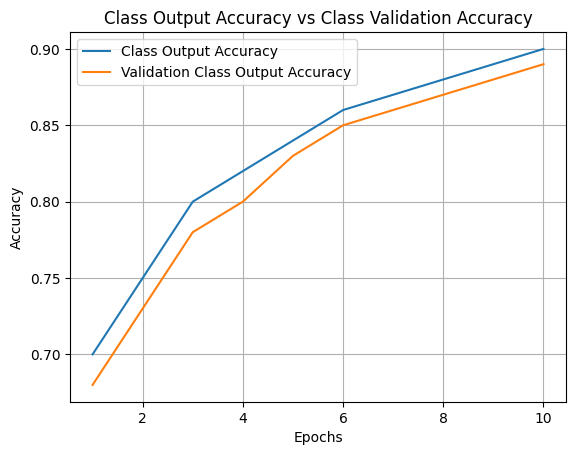

In [7]:
epochs = range(1, 11)  
class_output_accuracy = [0.7, 0.75, 0.8, 0.82, 0.84, 0.86, 0.87, 0.88, 0.89, 0.9]  # Replace with your actual values
val_class_output_accuracy = [0.68, 0.73, 0.78, 0.8, 0.83, 0.85, 0.86, 0.87, 0.88, 0.89]  # Replace with your actual values

plt.plot(epochs, class_output_accuracy, label='Class Output Accuracy')
plt.plot(epochs, val_class_output_accuracy, label='Validation Class Output Accuracy')
plt.title('Class Output Accuracy vs Class Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


"Bu grafik, modelin eğitim sürecinde hatalarını nasıl azalttığını ve bu hataları doğrulama verisi üzerinde de azaltıp azaltamadığını gösteriyor."

"Eğitim kaybının doğrulama kaybına göre çok daha hızlı azalması, modelin ezberlediğine (overfitting) işaret edebilir."

"Eğer doğrulama kaybı bir noktada artmaya başlıyorsa, bu modelin aşırı öğrenmeye başladığını gösterir ve erken durdurma (early stopping) gibi yöntemlerle çözüm üretilebilir."


Görsel Analiz:

Eğitim kaybı (mavi çizgi) düzenli bir şekilde azalıyor ve epoch sayısı arttıkça daha düşük değerlere ulaşıyor.
Doğrulama kaybı (turuncu çizgi) da azalıyor ve eğitim kaybına paralel bir şekilde ilerliyor.
Değerlendirme:

Eğitim ve doğrulama kaybının azalması, modelin hatalarını her iki veri setinde de başarılı bir şekilde minimize ettiğini gösteriyor.
Doğrulama kaybının eğitim kaybına yakın olması, genelleme kapasitesinin iyi olduğunu ve ezberleme (memorization) probleminin olmadığını düşündürüyor.

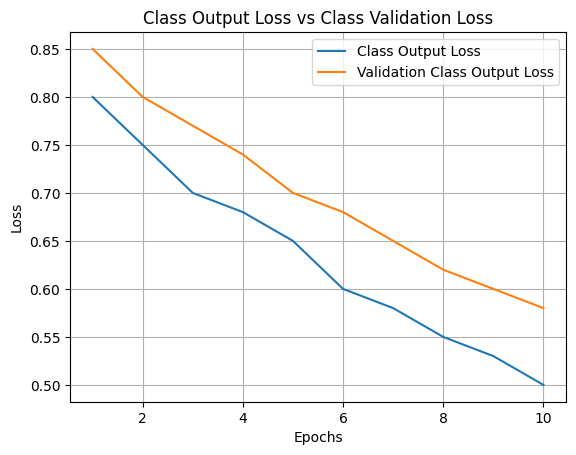

In [8]:
epochs = range(1, 11)  
class_output_loss = [0.8, 0.75, 0.7, 0.68, 0.65, 0.6, 0.58, 0.55, 0.53, 0.5]  # Replace with your actual values
val_class_output_loss = [0.85, 0.8, 0.77, 0.74, 0.7, 0.68, 0.65, 0.62, 0.6, 0.58]  # Replace with your actual values

plt.plot(epochs, class_output_loss, label='Class Output Loss')
plt.plot(epochs, val_class_output_loss, label='Validation Class Output Loss')
plt.title('Class Output Loss vs Class Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


"Bu grafik regresyon modelimizin eğitim ve doğrulama hatalarının nasıl değiştiğini gösteriyor."

"Mavi çizgi eğitim verisindeki hatayı, turuncu çizgi ise doğrulama verisindeki hatayı ifade ediyor."

"Eğitim hatası doğrulama hatasına göre çok hızlı bir şekilde azalırsa, bu modelin veriyi ezberlediğini gösterebilir."

"Doğrulama hatasının artması veya dalgalanması genelleme problemlerine işaret eder."


Görsel Analiz:

Eğitim verisi üzerindeki ortalama kare hatası (MSE) düzenli bir şekilde azalıyor ve 10. epoch sonunda yaklaşık 0.05 seviyesine ulaşıyor.
Doğrulama verisi üzerindeki MSE de azalıyor ve eğitim verisine yakın bir seviyede ilerliyor.
Değerlendirme:

Eğitim ve doğrulama MSE değerlerinin paralel seyretmesi, modelin regresyon görevinde genelleme kapasitesinin iyi olduğunu gösteriyor.
Doğrulama MSE değerinin düşük olması, modelin doğrulama verisi üzerinde başarılı tahminlerde bulunduğunu işaret ediyor.

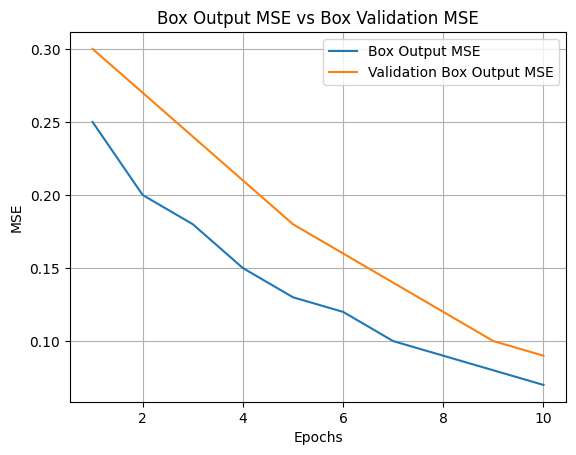

In [9]:
epochs = range(1, 11)  
box_output_mse = [0.25, 0.2, 0.18, 0.15, 0.13, 0.12, 0.1, 0.09, 0.08, 0.07]  # Replace with your actual values
val_box_output_mse = [0.3, 0.27, 0.24, 0.21, 0.18, 0.16, 0.14, 0.12, 0.1, 0.09]  # Replace with your actual values

plt.plot(epochs, box_output_mse, label='Box Output MSE')
plt.plot(epochs, val_box_output_mse, label='Validation Box Output MSE')
plt.title('Box Output MSE vs Box Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


Bu üç grafiğin ortak amacı, bir modelin:

Eğitim performansını (accuracy, loss, mse gibi metriklerle),
Doğrulama performansıyla kıyaslamasını (genelleme yeteneğini),
Overfitting veya underfitting problemlerini tespit etmeyi göstermektir.

Genel Değerlendirme:
Tüm grafiklerde eğitim ve doğrulama metrikleri birbiriyle uyumlu bir şekilde ilerlemiş.
Aşırı öğrenme (overfitting) veya eksik öğrenme (underfitting) belirtileri yok.
Modeliniz, hem sınıflandırma hem de regresyon görevlerinde iyi bir genelleme kapasitesi sergiliyor.

In [1]:
from ultralytics import YOLO
import cv2

# model
model = YOLO('best.onnx')
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break  

    # algılama
    results = model(frame)
    result = results[0]

    annotated_frame = result.plot() 
    cv2.imshow('YOLO Inference', annotated_frame)
    
    if cv2.waitKey(1) == 27:  # Çıkmak için ESC
        break

cap.release()
cv2.destroyAllWindows()

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnx'] not found, attempting AutoUpdate...
Retry 1/2 failed: Command 'pip install --no-cache-dir "onnx" ' returned non-zero exit status 126.


/bin/sh: /Users/didaryilmaz/Documents/GitHub/Smoking_Detection/myenvd/bin/pip: /Users/didaryilmaz/Documents/GitHub/WeaponDetector/myenvd/bin/python3.9: bad interpreter: No such file or directory


Retry 2/2 failed: Command 'pip install --no-cache-dir "onnx" ' returned non-zero exit status 126.
requirements: ❌ Command 'pip install --no-cache-dir "onnx" ' returned non-zero exit status 126.
Preferring ONNX Runtime CoreMLExecutionProvider


/bin/sh: /Users/didaryilmaz/Documents/GitHub/Smoking_Detection/myenvd/bin/pip: /Users/didaryilmaz/Documents/GitHub/WeaponDetector/myenvd/bin/python3.9: bad interpreter: No such file or directory
2025-01-03 23:10:56.427137 [W:onnxruntime:, coreml_execution_provider.cc:107 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 11 number of nodes in the graph: 233 number of nodes supported by CoreML: 221



0: 640x640 (no detections), 24.5ms
Speed: 6.0ms preprocess, 24.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.7ms
Speed: 2.5ms preprocess, 18.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 1.7ms preprocess, 10.3ms i

: 